# COGS 108 - Assignment 4: Data Analysis

# Important Reminders

- This assignment has hidden tests: tests that are not visible here, but that will be run on your submitted assignment for grading.
    - This means passing all the tests you can see in the notebook here does not guarantee you have the right answer!
    - In particular many of the tests you can see simply check that the right variable names exist. Hidden tests check the actual values. 
        - It is up to you to check the values, and make sure they seem reasonable.
- A reminder to restart the kernel and re-run the code as a first line check if things seem to go weird.
    - For example, note that some cells can only be run once, because they re-write a variable (for example, your dataframe), and change it in a way that means a second execution will fail. 
    - Also, running some cells out of order might change the dataframe in ways that may cause an error, which can be fixed by re-running.

Run the following cell. These are all you need for the assignment. Do not import additional packages.

In [1]:
# Imports 
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import patsy
import statsmodels.api as sm
import scipy.stats as stats
from scipy.stats import ttest_ind, chisquare, normaltest

# Note: the statsmodels import may print out a 'FutureWarning'. Thats fine.

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Notes - Assignment Outline

**Parts 1-6** of this assignment are modelled on being a minimal example of a project notebook. 
- This mimics, and gets you working with, something like what you will need for your final project.

**Parts 7 & 8** break from the project narrative, and are OPTIONAL (UNGRADED). 
- They serve instead as a couple of quick one-offs to get you working with some other methods that might be useful to incorporate into your project.

## Setup

Data: the responses collected from a survery of the COGS 108 class. 
- There are 417 observations in the data, covering 10 different 'features'.

Research Question: Do students in different majors have different heights?

Background: Physical height has previously shown to correlate with career choice, and career success. More recently it has been demonstrated that these correlations can actually be explained by height in high school, as opposed to height in adulthood (1). It is currently unclear whether height correlates with choice of major in university. 

Reference: 1) http://economics.sas.upenn.edu/~apostlew/paper/pdf/short.pdf

Hypothesis: We hypothesize that there will be a relation between height and chosen major. 

## Part 1: Load & Clean the Data


Fixing messy data makes up a large amount of the work of being a Data Scientist. 

The real world produces messy measurements and it is your job to find ways to standardize your data such that you can make useful analyses out of it. 

In this section, you will learn, and practice, how to successfully deal with unclean data.

### 1a) Load the data
Import datafile 'COGS108_IntroQuestionnaireData.csv' into a DataFrame called `df`.

In [2]:

# YOUR CODE HERE
df = pd.read_csv('COGS108_IntroQuestionnaireData.csv')

In [3]:
assert isinstance(df, pd.DataFrame)


In [4]:
# Check out the data
df.head(5)

,Timestamp,What year (in school) are you?,What is your major?,How old are you?,What is your gender?,What is your height?,What is your weight?,What is your eye color?,Were you born in California?,What is your favorite flavor of ice cream?
0,1/9/2018 14:49:40,4,Cognitive Science,21,Male,"5'8""",147,Brown,Yes,Vanilla
1,1/9/2018 14:49:45,3,Cognitive Science,20,Male,5'8,150,Brown,Yes,Cookies and Cream
2,1/9/2018 14:49:45,Third,Computer Science,21,Male,178cm,74kg,Black,Yes,Matcha
3,1/9/2018 14:49:45,2,Cogs HCI,20,Male,5’8,133,Brown,Yes,Cookies and Cream
4,1/9/2018 14:49:47,3,Computer Science,20,Male,"5'8""",160,Brown,Yes,Cookies n' Cream


Those column names are a bit excessive, so first let's rename them - code provided below to do so. 

In [5]:
# Renaming the columns of the dataframe
df.columns = ["timestamp", "year", "major", "age", "gender", "height",
              "weight", "eye_color", "born_in_CA", "favorite_icecream"]

Pandas has a very useful function for detecting missing data. This function is called 'isnull()'. 

If you have a dataframe called 'df', then calling 'df.isnull()' will return another dataframe of the same size as 'df' where every cell is either True of False. 

Each True or False is the answer to the question 'is the data in this cell null?'. So, False, means the cell is not null (and therefore, does have data). True means the cell is null (does not have data).

This function is very useful because it allows us to find missing data very quickly in our dataframe. As an example, consider the code below.

In [6]:
# Check the first few rows of the 'isnull' dataframe
df.isnull().head(5)

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
0,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False


If you print out more, and scroll down, you'll see some rows with missing data. 

In [7]:
# For example:
df.isnull().iloc[48:50, :]

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
48,False,False,False,False,False,False,False,False,False,False
49,False,True,False,False,False,True,True,False,False,False


 Check an example, row 49, in which an entry has missing data

In [8]:
df.iloc[49, :]

timestamp            1/9/2018 14:50:12
year                               NaN
major                          Cog Sci
age                                 21
gender                          Female
height                             NaN
weight                             NaN
eye_color                        Brown
born_in_CA                         Yes
favorite_icecream            Chocolate
Name: 49, dtype: object

Granted, the example above is not very informative. As you can see, the output of 'isnull()' is a dataframe where the values at each cell is either True or False. Most cells have the value of 'False'. We expect this to be the case since most people gave out answers to each question in our survey. 

However, some rows such as row 49 show that some people chose not to answer certain questions. In the case of row 49, it seems that someone did not give out an answer for 'What year (in school) are you?'

However, what if wanted to use 'isnull()' to see all rows where our dataframe 'df' has missing values? In other words, what if we want to see the ACTUAL rows with missing values instead of this dataframe with True or False cells. For that, we need to write the following line of code:
<br>
<br>
df[df.isnull().any(axis=1)]

### 1b) Find missing data
Find all rows that have missing data in them.

Save the ouput, as a dataframe, into a variable called `rows_to_drop`.

In other words, copy over and use the line of code that we gave out in the cell above.

In [9]:
# YOUR CODE HERE
rows_to_drop = df[df.isnull().any(axis = 1)]

In [10]:
assert isinstance(rows_to_drop, pd.DataFrame)
assert rows_to_drop.shape == (29, 10)

You need to run & read the following couple of cells - but don't have to add any code:

Real world data are messy. As an example of it, we consider the data shown in `rows_to_drop` (below).

If you've done everything correctly so far, you should see an unexpected response with emojis at index 357. These types of responses, although funny, are hard to parse when dealing with big datasets. 

We'll learn about solutions to these types of problems in the upcoming cells.

In [11]:
rows_to_drop

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
29,1/9/2018 14:50:00,senior,math&econ,20,female,173,130,black,No,NaN
38,1/9/2018 14:50:05,3rd,Computer Engineering,21,Female,NaN,NaN,Brown,No,NaN
49,1/9/2018 14:50:12,NaN,Cog Sci,21,Female,NaN,NaN,Brown,Yes,Chocolate
58,1/9/2018 14:50:14,3rd,Computer Science,20,Female,5ft 2in,NaN,brown,No,cookies and cream
66,1/9/2018 14:50:16,Sophomore,Cognitive Science - Design and Interaction,19,Female,5'5,NaN,Brown,No,Chubby hubby ben and jerrys
67,1/9/2018 14:50:16,2,Computer Science,19,Male,NaN,170,Brown,Yes,Chocolate
83,1/9/2018 14:50:23,Senior,Computer Science,22,Male,5'11,155 lb,dark brown,No,NaN
91,1/9/2018 14:50:25,Third,Computer Science,21,Female,NaN,NaN,Black,No,Green tea
92,1/9/2018 14:50:26,4,Computer Science,21,Female,"5'2""",NaN,Brown,Yes,Mint chip
133,1/9/2018 14:50:36,2018,computer science,22,male,NaN,NaN,brown,No,NaN


In the cell below, briefly explain below how 'df[df.isnull().any(axis=1)]' works, in a couple sentences. 

Include an explanation of what 'any(axis=1)' means and how it affects the code.

YOUR ANSWER HERE
<div>The code returns all the rows in the dataframe which has missing data in any cell of this row.</div>
<div>any(axis = 1) means that any cell of this row has the true value then it is true, it affects the code by choosing the rows. </div>

### 1c) Drop the rows with NaN values

Drop any rows with missing data, but only for the columns 'major', 'height', 'gender' and 'age'. These will be the data of primary interest for our analyses, so we drop missing data here. 

Note that there are other missing data (in other rows) but this is fine for our analyses, so we keep them. 

To do this, use the pandas `dropna` method, inplace, using the `subset` arguments to specify columns.

In [12]:
# YOUR CODE HERE
df.dropna(axis = 0,subset = ['major','height','gender','age'],inplace = True )

In [13]:
assert df.shape == (404, 10)

Now we have to standardize the data!

Check all different values given for majors. It's a lot!

In [14]:
df["major"].unique()

array(['Cognitive Science', 'Computer Science', 'Cogs HCI',
       'Cognitive Science w/ a specialization in Computation',
       'International Studies', 'Computer Engineering', 'computer science',
       'Chemical Engineering / Literature Writing',
       'Cognitive Science w/ Specialization in Human Computer Interaction',
       'Cognitive Science-- Machine Learning and Neural Computation ',
       'Cse', 'Cognitive Science - Design and Interaction',
       'cognitive science', 'CSE', 'Cog sci design interaction', 'Math CS',
       'Electrical Engineering', 'math&econ',
       'Cognitive Science spec/ HCI', 'Cognitive science', 'Math-CS',
       'Data Science', 'Cognitive science ', 'Cognitive Science ',
       'Math - CS ', 'Cognitive Science Human Computer Interaction',
       'Cognitive Science with specialization in HCI ',
       'Cognitive Science (HCI)', 'Probability & Statistics', 'Cog Sci',
       'Cognitive Science - Machine Learning',
       'Mathematics-computer science',

We'll write a function performing some simple substring checking in order to group many responses together.

In [15]:
def standardize_major(string):
    
    string = string.lower()
    string = string.strip()
    
    if "cog" in string:
        output = "COGSCI"
    elif "computer" in string:
        output = "COMPSCI"
    elif "cs" in string:
        output = "COMPSCI"
    elif "math" in string:
        output = "MATH"
    elif "electrical" in string:
        output = "ECE"
    elif "bio" in string:
        output = "BIO"
    elif "chem" in string:
        output = "CHEM"
    # Otherwise, if uncaught - keep as is
    else:
        output = string
    
    return output

We then have to apply the transformation using the function we just defined.

In [16]:
df["major"] = df["major"].apply(standardize_major)

Previewing the results of the previous transformation.

It looks a lot better, though it's not perfect, but we'll run with this.

In [17]:
df["major"].unique()

array(['COGSCI', 'COMPSCI', 'international studies', 'CHEM', 'ECE', 'MATH',
       'data science', 'political science', 'BIO', 'psychology',
       'physiology and neuroscience', 'management science',
       'interdisciplinary computing & the arts', 'machine learning',
       'neuroscience', 'under-water basket weaving'], dtype=object)

Next let's check the 'gender' column. 

Check the different responses received for gender, including how many of each response we have

In [18]:
df["gender"].value_counts()

Male                 229
Female                95
female                26
male                  18
F                     10
M                      6
Male                   6
Female                 6
Apache Helicopter      1
MALE                   1
Famale                 1
Transgender            1
Nonbinary              1
men                    1
Rainbow                1
Woman                  1
Name: gender, dtype: int64

Below you see `standardize_gender`: Function to standardize the gender responses

Note: for the purposes of the following analyses, we will keep self-reported gender for categories in which we have a sizable number of responses, in this case, those which correspond to 'female' and 'male'

In [19]:
# Function to standardize the gender responses
def standardize_gender(gender):
    
    gender = gender.lower()
    gender = gender.strip()
    
    if gender in ['female', 'f', 'woman', 'women']:
        output = 'female'
    elif gender in ['male', 'm', 'man', 'men']:
        output = 'male'
    else: 
        output = np.nan
    
    return output

Apply the transformation, and drop any rows with missing gender information


In [20]:
df["gender"] = df["gender"].apply(standardize_gender)
df.dropna(subset=['gender'], inplace=True)

In [21]:
# Check the results
df["gender"].unique()

array(['male', 'female'], dtype=object)

Now *you* will write some code to standardize some of the other data columns.

### 1d) Standardize other columns 
Find, programatically, the number of unique responses to in the 'year' column.

Save the result in a variable named `num_unique_responses`. 

Hint: you can answer this question using the `unique` method, used above. 

In [22]:
# YOUR CODE HERE
num_unique_responses = len(df['year'].unique())

In [23]:
assert num_unique_responses
assert isinstance(num_unique_responses, int)


In [24]:
# Print out all the different answers in 'year'
df['year'].unique()

array(['4', '3', 'Third', '2', '3rd', '3rd year', '5th', 'Second',
       '4th Year', '5', 'Senior', 'Junior', '2nd', '1', 'senior', 'third',
       'first year', '4th', 'Junior ', 'Freshman', 'Sophomore', '4th year',
       '6', 'second year', 'Third Year', '2nd year', 'First',
       '5th (2nd year transfer)', '2018', 'last year', 'UCSD',
       'Fifth Year', '2021', 'Fifth year', '3rd Year', '3rd year ',
       'Second year', 'fourth year', 'First year', 'Sophmore',
       'Second Year', 'Junior year', '2020', 'Fifth ', 'Sophomore ',
       '2nd year ', '4th year ', '2nd Year', '4+', 'second', 'Fourth',
       'Senior Year', '2nd (Sophomore)', 'Senior ', ' 3rd Year',
       'Fourth Year', 'Junior standing', 'Fourth year', 'Fifth',
       'Third year', 'Sineor '], dtype=object)

The line of code above shows us the different values we got, to the question 'What year (in school) are you?'.

As you can tell, it is a <b>mess</b>!. For example, if you are a junior student, then you might have answered: 3, three, third, 3rd year, junior, junior year, Junior, etc. 

That is an issue. We want to be able to analyze this data and, in order to do this successfully, we need to all answers with the same meaning to be written in the same way. Therefore, we're gonna have to transform answers such as '3, third, 3rd, junior, etc' into a single possible value. We'll do this for all values that mean the same. 

In the rest of Part 1, we will work on writing code, organized into functions that will allow us to transform similar respones into the same value. We will call this process: standardizing the data. 

The cell below provides an example for the kind of code you will need to write to answer this question. This example is separate from our actual data, and is a potential function we might use to standardize messy data - in this case, hypothetical data to the question 'What is your favourite major python version?'. 

Note some things used in this example that you need to use to standardize data:
- string methods, such as `lower` and `strip` to transform strings
- the `replace` string method, to replace a set of characters with something else
- if/else statements that check what's in our string (number, letters, etc)
- type casting, for example using `int()` to turn a variable into an integer
- using `np.nan` (which stands for 'not a number') to denote missing or unknown data

In [25]:
def example_standardize_function(str_in):
    """Standardize data to the question 'what is your favorite major python version?'
    
    Parameters
    ----------
    str_in : string
        A provided answer.
        
    Returns
    -------
    int_out : int or np.nan
        A standardized integer response.
    """
    
    # Make the input all lowercase
    str_in = str_in.lower()
    
    # Drop all whitespace
    str_in = str_in.strip()
    
    # Replace things (and then strip again afterwords)
    #  Note that the 'replace' replaces the first argument, with the second
    #   The first argument does not need to be present in the string,
    #    if it's not there 'replace' does nothing (but does not error), so the code moves on.
    str_in = str_in.replace('version', '')
    str_in = str_in.replace('python', '')
    str_in = str_in.strip()
    
    # Cast to integer, if what's left seems appropriate
    if str_in.isnumeric() and len(str_in) == 1:
        out = int(str_in)
    # Otherwise, consider input was probably ill-formed, return nan
    else: 
        out = np.nan
    
    return out

# Check how this function help standardize data:
#  Example possible answers to the question 'What is your favourite major version of Python':
print('INPUT', '\t\t-\t', 'OUTPUT')
for inp in ['version 3', '42', '2', 'python 3', 'nonsense-lolz']:
    print('{:10s} \t-\t {:1.0f}'.format(inp, example_standardize_function(inp)))

INPUT 		-	 OUTPUT
version 3  	-	 3
42         	-	 nan
2          	-	 2
python 3   	-	 3
nonsense-lolz 	-	 nan


### 1e)  Standardize 'year' column

Write a function named `standardize_year` that takes in as input a string and returns an integer.

The function will do the following (in the order specified):

Note that for these detailed instructions, each line corresponds to one line of code you need to write.

- 1) convert all characters of the string into lowercase
- 2) strip the string of all leading and trailing whitespace
- 3) replace any occurences of 'first' with '1'
- 4) replace any occurences of 'second' with '2'
- 5) replace any occurences of 'third' with '3'
- 6) replace any occurences of 'fourth' with '4'
- 7) replace any occurences of 'fifth' with '5'
- 8) replace any occurences of 'sixth' with '6'

- 9) replace any occurences of 'freshman' with '1'
- 10) replace any occurences of 'sophomore' with '2'
- 11) replace any occurences of 'junior' with '3'
- 12) replace any occurences of 'senior' with 4'
- 13) replace any occurences of 'year' with '' (remove it from the string)
- 14) replace any occurences of 'th' with '' (remove it from the string)
- 15) replace any occurences of 'rd' with '' (remove it from the string)
- 16) replace any occurences of 'nd' with '' (remove it from the string)
- 17) strip the string of all leading and trailing whitespace (again)
- 18) If the resulting string is a number and it is less than 10, then cast it into an integer and return that value
- 19) Else return np.nan to symbolize that the student's response was not a valid entry

HINTS: you will need to use the functions `lower()`, `strip()`, `isnumeric()` and `replace()`

In [26]:
# YOUR CODE HERE
def standardize_year(str_in):
    """Standardize data to the question 'what is your favorite major python version?'
    
    Parameters
    ----------
    str_in : string
        A provided answer.
        
    Returns
    -------
    int_out : int or np.nan
        A standardized integer response.
    """
    
    # Make the input all lowercase
    str_in = str(str_in).lower()
    
    # Drop all whitespace
    str_in = str_in.strip()
    
    # Replace things (and then strip again afterwords)
    #  Note that the 'replace' replaces the first argument, with the second
    #   The first argument does not need to be present in the string,
    #    if it's not there 'replace' does nothing (but does not error), so the code moves on.
    str_in = str_in.replace('first', '1')
    str_in = str_in.replace('second', '2')
    str_in = str_in.replace('third', '3')
    str_in = str_in.replace('fourth','4')
    str_in = str_in.replace('fifth', '5')
    str_in = str_in.replace('sixth', '6')
    str_in = str_in.replace('freshman','1')
    str_in = str_in.replace('sophomore', '2')
    str_in = str_in.replace('junior', '3')
    str_in = str_in.replace('senior','4')
    str_in = str_in.replace('year','')
    str_in = str_in.replace('th','')
    str_in = str_in.replace('rd','')
    str_in = str_in.replace('nd','')
    str_in = str_in.strip()

    # Cast to integer, if what's left seems appropriate
    if str_in.isnumeric() and len(str_in) == 1:
        out = int(str_in)
    # Otherwise, consider input was probably ill-formed, return nan
    else: 
        out = np.nan
    
    return out

In [27]:
assert standardize_year('2nd') == 2
assert standardize_year('sophomore') == 2
assert standardize_year('3rd year') == 3
assert standardize_year('5th') == 5
assert standardize_year('7    ') == 7
assert standardize_year('randomText') is np.nan

### 1f) Transform 'year' column

Use `standardize_year` to transform the data in column 'What year (in school) are you?'.

Hint: use the `apply` function AND remember to save your output inside the dataframe

In [28]:

# YOUR CODE HERE
df['year'] = df['year'].apply(standardize_year)

In [29]:
assert len(df["year"].unique()) == 7

Assuming that all is correct up to this point, the line below should show all values now found in df. 

It should look a lot better. With this data, we can now make insightful analyses.

You should see an array with elements 1,2,3,4,5,6 and nan (not necessarily in that order).

Note that if you check the data type of this column, you'll see that pandas converts these numbers to 'float', even though the applied function returns 'int', because 'np.nan' is considered a float. This is fine. 

In [30]:
df["year"].unique()

array([  4.,   3.,   2.,   5.,   1.,   6.,  nan])

Let's do it again. Let's take a look at the responses in the 'weight' column, and then standardize them.

In [31]:
# First, ensure that all types are consistent, use strings
df["weight"] = df["weight"].astype(str)

In [32]:
# Check all the different answers we received
df["weight"].unique()

array(['147', '150', '74kg', '133', '160', '106 lb', '155', '170 pounds',
       '170', '135', '115', '110', '167 lbs', '60kg', '136', '140', '120',
       '78kg', '128 lbs', '220', '145lb', '180', '95', '160lbs', '130',
       '177g', '125 pounds', '125', '210', '69kg', '165', '160 lbs', '123',
       '135lbs', '112 pounds', '190', '145lbs', '150 lbs', 'nan', '173lbs',
       '73kg', '133 lb', '107 pounds', '200', '240', '47kg', '175',
       '120 lbs', '164', '110 lbs', '128lbs', '155 lb', '185', '167',
       '84 kg', '113', '235', '128lb', '119 lbs', '110 lb', '72kg', '122',
       '140 lbs', '70 kg', '155 pounds ', '128', '125 lb', '108', '15',
       '215', '48kg', '52kg', '145', '185lbs. ', '230lb', '125 lbs',
       '140 lb', '168lb', '100', '130 pounds', '124', '84kg', '119',
       "I don't know dude but heavy probably", '103', '140lbs', '170lbs',
       '155 lbs', '50kg', '190 lbs', '52 kg', '168lbs', '189', '168',
       '76KG', '77kg', '181', '146', '156', '140 pounds', '1

### 1g) Standardize 'weight' column 

Write a function named `standardize_weight` that takes in as input a string and returns an integer.

The function will do the following (in the order specified):

- 1) convert all characters of the string into lowercase
- 2) strip the string of all leading and trailing whitespace
- 3) replace any occurences of 'lbs' with '' (remove it from the string)
- 4) replace any occurences of 'lb' with '' (remove it from the string)
- 5) replace any occurences of 'pounds' with '' (remove it from the string)
- 6) If the string contains the substring 'kg', then:
    - 6.1) replace 'kg' with ''
    - 6.2) cast the string into an integer type using the function 'int()'
    - 6.3) multiply the resulting integer by 2 (an approximate conversion of kilograms to pounds)
    - 6.4) cast the resulting number back into a string with the function `str()`
- 7) Strip the string of its whitespaces (again)
- 8) If the resulting string is numeric: cast it into an integer and return the resulting value
- 9) Else: return `np.nan`

In [33]:
# YOUR CODE HERE
def standardize_weight(str_in):
    """Standardize data to the question 'what is your favorite major python version?'
    
    Parameters
    ----------
    str_in : string
        A provided answer.
        
    Returns
    -------
    int_out : int or np.nan
        A standardized integer response.
    """
    
    # Make the input all lowercase
    str_in = str(str_in).lower()
    
    # Drop all whitespace
    str_in = str_in.strip()
    
    # Replace things (and then strip again afterwords)
    #  Note that the 'replace' replaces the first argument, with the second
    #   The first argument does not need to be present in the string,
    #    if it's not there 'replace' does nothing (but does not error), so the code moves on.
    str_in = str_in.replace('lbs', '')
    str_in = str_in.replace('lb', '')
    str_in = str_in.replace('pounds', '')
    if ('kg' in str_in):
        str_in = str(2*int(str_in.replace('kg','')))
    
    str_in = str_in.strip()

    # Cast to integer, if what's left seems appropriate
    if str_in.isnumeric():
        out = int(str_in)
    # Otherwise, consider input was probably ill-formed, return nan
    else: 
        out = np.nan
    
    return out

In [34]:
assert standardize_weight('34 lbs') == 34
assert standardize_weight('101 kg') == 202


### 1h) Transform 'weight' column 

Use `standardize_weight` to transform the data in the 'weight' column.

Hint: use the `apply` function AND remember to save your output inside the dataframe

In [35]:
# YOUR CODE HERE
df['weight'] = df['weight'].apply(standardize_weight)

In [36]:
assert df["weight"].unique().shape == (83,)

Now, let's see the result of our hard work . The code below should output all numbers (or nan).

In [37]:
df["weight"].unique()

array([ 147.,  150.,  148.,  133.,  160.,  106.,  155.,  170.,  135.,
        115.,  110.,  167.,  120.,  136.,  140.,  156.,  128.,  220.,
        145.,  180.,   95.,  130.,   nan,  125.,  210.,  138.,  165.,
        123.,  112.,  190.,  173.,  146.,  107.,  200.,  240.,   94.,
        175.,  164.,  185.,  168.,  113.,  235.,  119.,  144.,  122.,
        108.,   15.,  215.,   96.,  104.,  230.,  100.,  124.,  103.,
        189.,  152.,  154.,  181.,   92.,  169.,  250.,  116.,  132.,
        134.,  102.,  105.,  320.,  142.,  280.,   58.,  129.,  141.,
         98.,  182.,  205.,   90.,  179.,  158.,   91.,   75.,  114.,
         85.,  126.])

So far, you've gotten a taste of what it is like to deal with messy data. It's not easy, as you can tell. 

The last variable we need to standardize for the purposes of our analysis is 'height'. We will standardize that one for you.

Do read the code below and try to understand what it is doing.

In [38]:
# First, we'll look at the possible values for height
df["height"].unique()

array(['5\'8"', "5'8", '178cm', '5’8', '5\'11"', "5'9", '5 ft, 3 in',
       "5'10", '180 cm', '5\'3"', '5\'9"', '5\'2"', '5ft 5inches', '158cm',
       '5\'7"', '5 feet 8 inches', "5'7''", "5' 8'' ", '184cm', '5\' 7"',
       '6’2”', "6'1''", "4'11", '5\'10"', '173', '177cm', '5\'6"', "5'4",
       '5’5', "5'5", "6'2", '171cm', "5' 5''", "5'2", "5'7", '5\' 8"',
       "5'3", '5 feet 9 inches', '6’0', '5’3', "5'11", '64 in', "5' 7''",
       '5ft 2in', '5’3”', '66', '173cm', '5’8”', '5 feet 2 in', '5 7',
       '6’', '5.4', '6 feet', '5’0”', '1.6m', '5 ft 2 in', '5\'1"', '5’5”',
       "5' 8''", '6\'2"', '6\'4"', '5\'8.5"', '178 cm', '5\'5"', "6'1",
       '5”7’', '174cm', '71', "5' 1", '6 ft', '5” 4’', '177 cm',
       '69 inches ', "5'4''", '5\' 4"', '5 foot 11', "5''2'",
       '6 feet 0 inches', '67', '167cm', '6\'1"', "5'11''", '168cm', '5"8',
       '5\' 10"', '6ft', '163 cm', '5 Feet 6 inches', '6.1', "5' 3''",
       '5 foot 7', '5 ft 3', '5 7"', '172 cm', '6-5', '5’ 6’’', '6’0

It seems like we'll have to handle different measurement systems. Ugh, ok...


Let's write a function that converts all those values to inches.

In [39]:
# convert all values to inches
def standardize_height(string):
    
    orig = string
    output = None
    
    # Basic string pre-processing
    string = string.lower()
    string = string.strip()
    
    string = string.replace("foot", "ft")
    string = string.replace("feet", "ft")
    string = string.replace("inches", "in")
    string = string.replace("inch", "in")
    string = string.replace("meters", "m")
    string = string.replace("meter", "m")
    string = string.replace("centimeters", "cm")
    string = string.replace("centimeter", "cm")
    string = string.replace(",", "")
    string = string.strip()
    
    # CASE 1: string is written in the format FEET <DIVIDER> INCHES
    dividers = ["'", "ft", "’", '”', '"','`', "-", "''"]
    for divider in dividers:
        
        # Split it into its elements
        elements = string.split(divider)

        # If the divider creates two elements
        if (len(elements) >= 2) and ((len(string) -1) != string.find(divider)):
            feet = elements[0]
            inch = elements[1] if elements[1] is not '' else '0'
            
            # Cleaning extranious symbols
            for symbol in dividers:
                feet = feet.replace(symbol, "")
                inch = inch.replace(symbol, "")
                inch = inch.replace("in","")
            
            # Removing whitespace
            feet = feet.strip()
            inch = inch.strip()
            
            # By this point, we expect 'feet' and 'inch' to be numeric
            # If not...we ignore this case
            if feet.replace('.', '').isnumeric() and inch.replace('.', '').isnumeric():
                
                # Converting feet to inches and adding it to the curent inches
                output = (float(feet) * 12) + float(inch)
                break
            
    # CASE 2: string is written in the format FEET ft INCHES in 
    if ("ft" in string) and ("in" in string):
        
        # Split it into its elements
        elements = string.split("ft")
        feet = elements[0]
        inch = elements[1]
        
        # Removing extroneous symbols and stripping whitespace
        inch = inch.replace("inch", "")
        inch = inch.replace("in", "")
        feet = feet.strip()
        inch = inch.strip()
        
        # By this point, we expect 'feet' and 'inch' to be numeric
        # If not...we ignore this case
        if feet.replace('.', '').isnumeric() and inch.replace('.', '').isnumeric():
                
            # Converting feet to inches and adding it to the curent inches
            output = (float(feet) * 12) + float(inch)
        
    # CASE 3: answer was given ONLY in cm
    #  Convert to inches: approximately 0.39 inches in a meter
    elif "cm" in string:
        centimeters = string.replace("cm", "")
        centimeters = centimeters.strip()
        
        if centimeters.replace('.', '').isnumeric():
            output = float(centimeters) * 0.39
        
    # CASE 4: answer was given ONLY in meters
    #  Convert to inches: approximately 39 inches in a meter
    elif "m" in string:
        
        meters = string.replace("m", "")
        meters = meters.strip()
        
        if meters.replace('.', '').isnumeric():
            output = float(meters)*39
        
    # CASE 5: answer was given ONLY in feet
    elif "ft" in string:

        feet = string.replace("ft", "")
        feet = feet.strip()
        
        if feet.replace('.', '').isnumeric():
            output = float(feet)*12
    
    # CASE 6: answer was given ONLY in inches
    elif "in" in string:
        inches = string.replace("in", "")
        inches = inches.strip()
        
        if inches.replace('.', '').isnumeric():
            output = float(inches)
        
    # CASE 7: answer not covered by existing scenarios / was invalid. 
    #  Return NaN
    if not output:
        output = np.nan

    return output

In [40]:
# Applying the transformation and dropping invalid rows
df["height"] = df["height"].apply(standardize_height)
df.dropna(subset=['height'], inplace=True)

In [41]:
# Check the height data, after applying our standardization
df["height"].unique()

array([ 68.  ,  69.42,  71.  ,  69.  ,  63.  ,  70.  ,  70.2 ,  62.  ,
        65.  ,  61.62,  67.  ,  71.76,  74.  ,  73.  ,  59.  ,  69.03,
        66.  ,  64.  ,  66.69,  72.  ,  67.47,  60.  ,  62.4 ,  61.  ,
        76.  ,  68.5 ,  67.86,  65.13,  65.52,  63.57,  67.08,  77.  ,
        66.3 ,  74.1 ,  62.79,  75.  ,  63.18,  72.15,  68.64,  68.25,
        69.81,  66.5 ,  73.5 ,  72.54,  63.75,  58.  ])

In [42]:
# Ensuring that the data types are correct - type cast age to int.
df["age"] = df["age"].astype(np.int64)

# Check out the data, after we've cleaned it!
df.head()

,timestamp,year,major,age,gender,height,weight,eye_color,born_in_CA,favorite_icecream
0,1/9/2018 14:49:40,4.0,COGSCI,21,male,68.00,147.0,Brown,Yes,Vanilla
1,1/9/2018 14:49:45,3.0,COGSCI,20,male,68.00,150.0,Brown,Yes,Cookies and Cream
2,1/9/2018 14:49:45,3.0,COMPSCI,21,male,69.42,148.0,Black,Yes,Matcha
3,1/9/2018 14:49:45,2.0,COGSCI,20,male,68.00,133.0,Brown,Yes,Cookies and Cream
4,1/9/2018 14:49:47,3.0,COMPSCI,20,male,68.00,160.0,Brown,Yes,Cookies n' Cream


In [43]:
# Check that the dataframe has the right number of columns
#  If this doesn't pass - check your code in the section above.
assert len(df) == 367

## Part 2: Exploratory Data Vizualization

First, we need to do some exploratory data visualization, to get a feel for the data. 

For plotting questions, do not change or move the 'plt.gcf()' lines. 

### 2a) Plot the data

Using `scatter_matrix`, from `pandas`, plot `df`. Assign it to a variable called `fig`.


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.scatter_matrix is deprecated, use pandas.plotting.scatter_matrix instead
  This is separate from the ipykernel package so we can avoid doing imports until


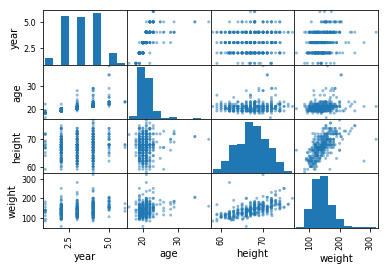

In [44]:

# YOUR CODE HERE
fig = pd.scatter_matrix(df)

In [45]:
assert np.all(fig)

### 2b) Plot a bar chart showing the number of students in each major. 

Hint: you can use `value_counts` to get the counts for each major. You can then use the `plot` method from `pandas` for plotting - you don't need `matplotlib`. 


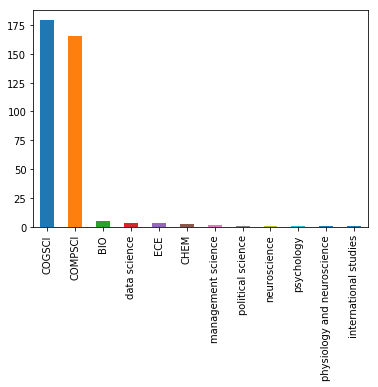

In [46]:

# YOUR CODE HERE
df['major'].value_counts().plot("bar")

f1 = plt.gcf()

In [47]:
assert f1.gca().has_data()

### 2c) Plot a histogram of the height data for all students who wrote 'COGSCI' as their major.


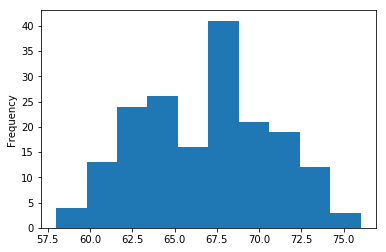

In [48]:

# YOUR CODE HERE
df.loc[df['major'] == 'COGSCI']['height'].plot.hist()

f2 = plt.gcf()

In [49]:
assert f2.gca().has_data()

### 2d) Plot a histogram of the height data for all students who wrote 'COMPSCI' as their major.


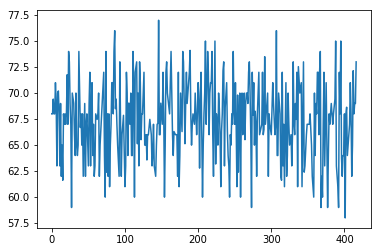

In [50]:

# YOUR CODE HERE
f3 = df['height'].plot(subplots = False)

f3 = plt.gcf()

In [51]:
assert f3.gca().has_data()

## Part 3: Exploring The Data

Beyond just plotting the data, we should check some other basic properties of the data. This serves both as a way to get a 'feel' for the data, and to look for any quirks or oddities about the data, that may indicate issues that need resolving. To do this, let's explore that data a bit (not limiting ourselves to only features that we plan to use - exploring the dataset as a whole can help us find any issues). 

Notes:
- You answers should NOT be pandas objects (Series or DataFrames), extract answers so the variables are ints, floats or strings (as appropriate).
- You must answer these questions programmatically: do not count / check and hard code particular values.

### 3a) How many different majors are in the dataset?

Save this number to a variable `n_majors`.

In [52]:
# YOUR CODE HERE
n_majors = len(df['major'].unique())
n_majors

12

In [53]:
assert n_majors


### 3b) What is the range (max value - min value) of ages in the dataset?

Save this number to a variable `r_age`.

In [54]:

# YOUR CODE HERE
r_age = max(df['age'])-min(df['age'])
r_age

23

In [55]:
assert r_age


### 3c) What is the most popular ice cream flavor?

Save the ice cream name to the variable `f_ice`, and the number of people who like it to a variable `n_ice`.

Hint: you can get these values using the `value_counts` method.


In [56]:

# YOUR CODE HERE
n_ice = df['favorite_icecream'].value_counts()[0]
f_ice = df['favorite_icecream'].value_counts().index[0]
n_ice
f_ice

'Vanilla'

In [57]:
df['favorite_icecream'].value_counts().index

Index(['Vanilla', 'Strawberry', 'Chocolate', 'Cookies and Cream',
       'Mint Chocolate Chip', 'Pistachio', 'Coffee', 'cookies and cream',
       'Mint', 'Green tea',
       ...
       'cookies n cream ', 'Matcha/ Green Tea', 'Mint chip ', 'chocolate ',
       'I don't like ice cream.', 'Birthday Cake',
       'Chocolate chip cookie dough', 'Vanilla Honey Lavendar', 'Brownie',
       'Cookie and Cream'],
      dtype='object', length=150)

In [58]:
assert n_ice
assert f_ice


### 3d) How many people have a unique favorite ice cream? (In other words: how many ice cream flavors are only 1 person's favorite?)

Save this number to a variable `u_ice`.


In [59]:

# YOUR CODE HERE
u_ice = sum([i == 1 for i in df['favorite_icecream'].value_counts()])
u_ice

108

In [60]:
assert u_ice


### Part 4: Testing Distributions

Soon, in the data analysis, we will want to run some statistical tests on our data. First, we should check the distributions!

When using methods / statistical tests that make certain assumptions, it's always best to explicitly check if your data meet those assumptions (otherwise the results may be invalid). Let's test if our data are in fact normally distributed. 

See an example of how to test the disributions of data in the 'TestingDistributions' notebook in Tutorials.

For convenience, and consistency, we're providing this code to pull out the required data. Be sure to run the folowing cell and understand what it's doing.:


In [61]:
h_co = df[df['major'] == 'COGSCI']['height'].values
h_cs = df[df['major'] == 'COMPSCI']['height'].values

### 4a) Testing Normality

For each of `h_co`, and `h_cs`, use the `normaltest` function to test for normality of the distribution.

`normaltest` returns two values: (1) a test statistic and (2) a p-value

Save these values as `st_co`, `p_co`, `st_cs`, and `p_cs`, respectively.


In [62]:

# YOUR CODE HERE
st_co = normaltest(h_co).statistic
p_co = normaltest(h_co).pvalue
st_cs = normaltest(h_cs).statistic
p_cs = normaltest(h_cs).pvalue
print(st_co,p_co)
print(st_cs,p_cs)

8.22280200605 0.0163848032797
0.270865818535 0.873337753833


In [63]:
assert st_co
assert p_co
assert st_cs
assert p_cs


Have a look at the values returned. 

Based on these results, and using an alpha significance value of 0.01:

Set boolean values (`True`, `False`) of whether each distribution can be considered to be normally distributed (set as `True` if the test supports it is normally distributed (or, more formally, we have not rejected the null hypothesis), and `False` if the test suggests the data is not normally distributed (we should reject the null hypothesis).

# 4b) Set boolean values, as specified above.

For the `h_co` data, set a boolean value to the var `is_n_co`

For the `h_cs` data, set a boolean value to the var `is_n_cs`


In [64]:

# YOUR CODE HERE
is_n_co = True if p_co > 0.01 else False
is_n_cs = True if p_cs > 0.01 else False

In [65]:
assert isinstance(is_n_co, bool)
assert isinstance(is_n_cs, bool)


**CO data**: plot the comparison of the data and a normal distribution (this code provided)

This plots a histogram, with the hypothetical normal distribution (with same mean and variance)


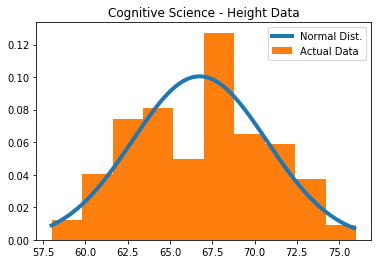

In [66]:
xs = np.arange(h_co.min(), h_co.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(h_co), np.std(h_co))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(h_co, density=True, label='Actual Data');
plt.title('Cognitive Science - Height Data')
plt.legend();

**CS data**: plot the comparison of the data and a normal distribution (this code provided)

This plots a histogram, with the hypothetical normal distribution (with same mean and variance)


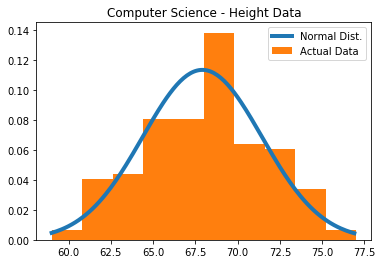

In [67]:
xs = np.arange(h_cs.min(), h_cs.max(), 0.1)
fit = stats.norm.pdf(xs, np.mean(h_cs), np.std(h_cs))
plt.plot(xs, fit, label='Normal Dist.', lw=4)
plt.hist(h_cs, density=True, label='Actual Data');
plt.title('Computer Science - Height Data')
plt.legend();

## Part 5: Data Analysis

Now let's analyze the data, to address our research question.

For the purposes of this analysis, let's assume we need at least 75 students per major to analyze the height data. 

This means we are only going to use data from people who wrote 'COGSCI' or 'COMPSCI' as their major. 


### 5a) Pull out the data we are going to use:

Save the height data for all 'COGSCI' majors to a variable called `h_co`

Save the height data for all 'COMPSCI' majors to a variable called `h_cs`

In [68]:

# YOUR CODE HERE
h_co = df[df['major'] == 'COGSCI']['height'].values
h_cs = df[df['major'] == 'COMPSCI']['height'].values

In [69]:
assert np.all(h_co)
assert np.all(h_cs)

assert len(h_co) == 179
assert len(h_cs) == 165

### 5b) What is the average (mean) height for students from each major?

Save these values to `avg_h_co` for COGSCI students, and `avg_h_cs` for COMPSCI students. 


In [70]:

# YOUR CODE HERE
avg_h_co = h_co.mean()
avg_h_cs = h_cs.mean()

In [71]:
assert avg_h_co
assert avg_h_cs


In [72]:
# Print out the average heights - this code provided
print('Average height of cogs majors is \t {:2.2f} inches'.format(avg_h_co))
print('Average height of cs majors is \t\t {:2.2f} inches'.format(avg_h_cs))

Average height of cogs majors is 	 66.75 inches
Average height of cs majors is 		 67.91 inches


Based on the cell above, it looks like there might indeed be a difference in the average height for students in cogs vs cs majors. 

Now we want to statistically test this difference. To do so, we will use a t-test. 

### 5c) Compare distribtuions: t-test 

Use the `ttest_ind` function) to compare the two height distributions (`h_co` vs `h_cs`)

`ttest_ind` returns a t-statistic, and a p-value. Save these outputs to `t_val` and `p_val` respectively. 


In [73]:

# YOUR CODE HERE
t_val = ttest_ind(h_co,h_cs).statistic
p_val = ttest_ind(h_co,h_cs).pvalue

In [74]:
assert t_val
assert p_val


In [75]:
# Check if statistical test passes significance, using an alpha value of 0.01. This code provided.
if p_val < 0.01:
    print('Data Science accomplished, there is a significant difference!')
else:
    print('There is NOT a significant difference!')
    
# Editorial note:
#  Chasing signitificant p-values as the goal itself is not actually a good way to do data (or any) science :)

Data Science accomplished, there is a significant difference!


Note: this test *should* pass significance. If it doesn't, double check your code up until this point.

So - we've reached a conclusion! We're done right!?

Nope. We have a first pass analysis, and an interim conclusion that happens to follow our hypothesis. 

Now let's try to break it. 

#### Let's explore some more

You should always interogate your findings, however they come out. What could be some alternate explanations, that would change our interpretations of the current analyses?

In this case, we should be worried about confounding variables. We want to be able to say whether height relates to major specifically, but it could be the case that some other variable, that happens to differ between majors, better explains the differences in height. 

In this case, we also have data on gender. Let's check if differences in the gender ratio of the two majors can explain the difference in height. 

### 5d) Digging Deeper

Using `value_counts` from pandas, extract the number of 'male' and 'female', separately for cogs and cs students. 

To do so:

- select from the `df` each major, separately, extract the gender column, and use the `value_counts` method.
- Save the counts for each gender for 'COGSCI' majors to a variable called `g_co`
-  Save the counts for each gender for 'COMPSCI' majors to a variable called `g_cs`


In [76]:

# YOUR CODE HERE
g_co = df[df['major']=='COGSCI']['gender'].value_counts()
g_cs = df[df['major']=='COMPSCI']['gender'].value_counts()

In [77]:
assert np.all(g_co)
assert np.all(g_cs)

assert g_co[0] == 93
assert g_cs[1] == 38

### 5e) What is the ratio of women in each major? 

By ratio, we mean the proportion of students that are female, as a ratio. This will be value between 0.0 and 1.0, calculated as #F / (#M + #F) - done separately for each major

You can use the `g_co` and `g_cs` variables to calculate these.

Save the ratio of women in COGSCI to a variable `r_co`.

Save the ratio of women in COMPSCI to a variable `r_cs`.

Note: keep these numbers as ratios (they should be decimal numbers, less than 1).


In [78]:

# YOUR CODE HERE
r_co = g_co[1] / sum(g_co)
r_cs = g_cs[1] / sum(g_cs)
print(r_co,r_cs)

0.480446927374 0.230303030303


In [79]:
assert r_co
assert r_cs


Make sure you print out and check the values of these ratios. They seem pretty different.

We can actually ask, using a chi-squared test, whether this difference in gender-ratio between the majors is signficantly different.

Code to do this is provided below. 

Run a chisquared test of the difference of ratios of categorical data between groups:


In [80]:
chisq, p_val_chi = stats.chisquare(np.array([g_co.values, g_cs.values]), axis=None)

if p_val_chi < 0.01:
    print('There is a significant difference in ratios!')

There is a significant difference in ratios!


### 5f) Subsetting data

Create a new dataframe, called `df2`, which only includes data from 'COGSCI' and 'COMPSCI' majors.

Hint: you can do this using the or operater '|', with loc. 


In [81]:

# YOUR CODE HERE
df2 = pd.DataFrame(df.loc[ (df['major'] == 'COGSCI') | (df['major'] == 'COMPSCI')])

In [82]:
assert isinstance(df2, pd.DataFrame)
assert df2.shape == (344, 10)
assert set(df2['major']) == set(['COGSCI', 'COMPSCI'])

### 5g) Pivot Tables

Another way to look at these kinds of comparisons is pivot tables. 

Use the pandas `pivot_table` method to create pivot table, assign it to a variable `pv`.

Set the values as'height', and the indices as 'gender' and 'major' in the pivot table.

Make sure you do this using `df2`. 


In [83]:

# YOUR CODE HERE
pv = pd.pivot_table(df2, values = ['height'],index = ['gender','major'])

In [84]:
assert np.all(pv)
assert isinstance(pv.index, pd.MultiIndex)


Print out the pivot table you just created. 

Compare the average height values, split up by major and gender.

Does it look like there are differences in heights by major, when spit up by major?


In [85]:
pv

height
gender major             
female COGSCI   63.708140
       COMPSCI  63.760789
male   COGSCI   69.557419
       COMPSCI  69.150709

Let's recap where we are:
- Our initial hypothesis suggested there is a significant difference between heights of people in different majors. 
- However, further analyses suggested there may be a confounding variable, as there is also a significantly different gender balance between majors. 

Checking the average height, per major, split up by gender, suggests there may not be a difference between major, other than what is explained by gender. 

Now we want to statistically ask this question: is there still a different in height between majors, when controlling for differences in gender. 

#### Linear Models

For the following question you will need to make some linear models, using Ordinary Least Squares (OLS).

There is more than one way to do this in Python. For the purposes of this assignment, you must use the method that is outlined in the 'LinearModels' Tutorial, using patsy, and statsmodels. 

That is: 
- Create design matrices with `patsy.dmatrices`
- Iniliaize an OLS model with `sm.OLS`
- Fit the OLS model
- Check the summary for results. 

### 5h) Linear model

Create a linear model to predict height from major (using `df2` as data).

Use `patsy.dmatrices` to create the design matrices, calling the outputs `outcome_1`, `predictors_1`.

Create an OLS model (`sm.OLS`) using `outcome_1` and `predictors_1`. Call it `mod_1`.

Fit the model, assigning it to `res_1`.

In [86]:


# YOUR CODE HERE
outcome_1, predictors_1 = patsy.dmatrices("height ~ major",df2)
mod_1 = sm.OLS(outcome_1, predictors_1)
res_1 = mod_1.fit()

In [87]:
assert isinstance(outcome_1, patsy.design_info.DesignMatrix)
assert isinstance(predictors_1, patsy.design_info.DesignMatrix)
assert isinstance(mod_1, sm.regression.linear_model.OLS)
assert isinstance(res_1, sm.regression.linear_model.RegressionResultsWrapper)


In [88]:
# Print out the summary results of the model fitting
print(res_1.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.020
Method:                 Least Squares   F-statistic:                     8.144
Date:                Sun, 26 May 2019   Prob (F-statistic):            0.00458
Time:                        20:40:34   Log-Likelihood:                -943.96
No. Observations:                 344   AIC:                             1892.
Df Residuals:                     342   BIC:                             1900.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           66.7472      0.282  

### 5i) Assess significance: `mod_1`

Based on the model you ran above (using alpha value of 0.01), does major significantly predict height?

Set your answer as a boolean (True / False) to a variable called `lm_1`.

In [89]:

# YOUR CODE HERE
lm_1 = True

In [90]:
assert isinstance(lm_1, bool)


### 5j) Multivariate regression

Create a linear model to predict height from both major and gender (using `df2` as data).

Use `patsy.dmatrices` to create the design matrices, calling the outputs `outcome_2`, `predictors_2`

Create an OLS model (`sm.OLS`) using `outcome_2` and `predictors_2`.  Call it `mod_2`.

Fit the model, assigning it to `res_2`.


In [91]:

# YOUR CODE HERE
outcome_2, predictors_2 = patsy.dmatrices("height ~ major + gender",df2)
mod_2 = sm.OLS(outcome_2, predictors_2)
res_2 = mod_2.fit()

In [92]:
assert isinstance(outcome_2, patsy.design_info.DesignMatrix)
assert isinstance(predictors_2, patsy.design_info.DesignMatrix)
assert isinstance(mod_2, sm.regression.linear_model.OLS)
assert isinstance(res_2, sm.regression.linear_model.RegressionResultsWrapper)


In [93]:
# Print out the results 
print(res_2.summary())

                            OLS Regression Results                            
Dep. Variable:                 height   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     170.2
Date:                Sun, 26 May 2019   Prob (F-statistic):           5.57e-52
Time:                        20:40:34   Log-Likelihood:                -828.95
No. Observations:                 344   AIC:                             1664.
Df Residuals:                     341   BIC:                             1675.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           63.8026      0.260  

#### 5k) Assess significance: `mod_2`

Based on the model you ran above (using alpha value of 0.01), does major significantly predict height?

Set your answer as a boolean (True / False) to a variable called `lm_2`

In [94]:

# YOUR CODE HERE
lm_2 = False

In [95]:
assert isinstance(lm_2, bool)


## Part 6: Discussion & Conclusions

### 6a) Conclusion

Set a boolean variables, called `ans`, as True or False as the answer to the following question:

We have evidence supporting our research question:

> People in different majors have systematically different heights (and this difference can be tied to their major).


In [96]:

# YOUR CODE HERE
ans = False

In [97]:
assert isinstance(ans, bool)


### 6b) Summary

Write a short response (1-2 sentence) summarizing the results.

Did we support our hypothesis? Why or why not? What turned out to be the finding(s).

YOUR ANSWER HERE
<div> Yes, according to 5h), we can conclude that major significantly predict height. However, when there is some other factor such as gender, the effect of major on height becomes less obvious. </div>



## Parts 7 & 8: Other Stuff - OPTIONAL!

These parts of the assignment (the rest of it) are completely OPTIONAL, and are ungraded.

The next couple sections break from the project narrative we've using above, and briefly explores some other topics, approaches and techniques that have (or will) be addressed in the class, and may be useful for you projects. 

This section is still set up like an assignment, asking you to answer questions to practice working with these methods, with the solutions posted later, but all tests for this section are public.

There are example of using these methods in the Tutorials.

In [98]:
# You will need the following functions for the last section of the assignment
#  You should not need to import any other functions
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
from sklearn.decomposition import PCA

### Part 7: Clustering

Suppose we have reason to believe there are distinct clusters of students in the class. However, we do not know which students are in which group, nor the boundaries that define the groups. 

This is a clustering problem - here you will use KMeans to dry and find the clusters from the data. 

See an example of how to use sklearn, and specifically KMeans, for clustering in the 'Clustering' notebook in the Tutorials.

In [99]:
# Make a copy of the dataframe, to work with here, and drop any empty data in columns we're using
df3 = df.copy(deep=True)
df3.dropna(subset=['age', 'weight', 'year'], inplace=True)

In [100]:
# For convenience, and consistency, we're providing this code to pull out the required data
d1 = df3[df3['major'] == 'COGSCI']['weight'].values
d2 = df3[df3['major'] == 'COGSCI']['age'].values

In [101]:
# 7a) For both 'd1', and 'd2' (separately) use the 'whiten' function to whiten the data. 
#  Save the outputs to 'd1w', and 'd2w' repectively. 
#  Note: look into what this function does, and why you might want or need to do it. 

# YOUR CODE HERE
raise NotImplementedError()

NotImplementedError: 

In [ ]:
assert np.all(d1w)
assert np.all(d2w)

assert round(np.var(d1w)) == 1
assert round(np.var(d2w)) == 1

In [ ]:
# 7b) Initialize a Kmeans model object. Call it 'km'.
#  Initialize it with 'n_clusters' of 2, and 'random_state' of 42.

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert isinstance(km, KMeans)

assert km.n_clusters == 2
assert km.random_state == 42

In [ ]:
# For convenience, and consistency, we're providing this code to combine the data into required format.
cl_dat = np.array([d1w, d2w]).T

In [ ]:
# 7c) Use the 'fit' method of the KMeans object (km) to fit the data ('cl_dat').

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert np.any(km.labels_)
assert sum(km.labels_) == 14

In [ ]:
# Let's check out our clusters (this code provided).
plt.scatter(d1, d2, c=km.labels_);
plt.xlabel('Weight');
plt.ylabel('Age');

Editorial note:
- It does not appear, for this data, that there are particular clusters (or at least not that our current KMeans approach is picking up), but that's fine, we can consider this to have been an exploratory analysis. 

### Part 8: Dimensionality Reduction

Sometimes we have data that have many dimensions, perhaps too many to deal with, and so we might need to try and use dimensionality reduction: that is to try and find a lower dimensional space that captures as much of the information as we can from the original, high-dimensional, dataset. 

As an example, in our data, we have height and weight that are quite correlated, and we could use Principal Components Analysis (PCA), in order to try and capture the most information about a persons' height and weight in a single number - projecting this 2D data down into 1 dimension. 

See an example of how to use sklearn, and specifcally PCA, for dimensionality reduction in the 'Dimensionality Reduction' notebook in the Tutorials.

In [ ]:
# Check out the height vs. weight data
plt.plot(df3['height'].values, df3['weight'].values, '.')
plt.xlabel('Height');
plt.ylabel('Weight');

In [ ]:
# For convenience, and consistency, we're providing this code to pull out the required data
d1_h = df3['height'].values
d2_w = df3['weight'].values

In [ ]:
# 8a) Initialize a PCA object. Call it 'dr'. 
#  Initialize it with 'n_components' of 1, and 'whiten' as True.

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert isinstance(dr, PCA)

assert dr.n_components == 1
assert dr.whiten

In [ ]:
# For convenience, and consistency, we're providing this code to combine the data into required format
dr_dat = np.array([d1_h, d2_w]).T

In [ ]:
# 8b) Use the 'fit_transform' method of the PCA object (dr) on the data ('dr_dat')
#  This method fits the dimensionality reduction model, and then transforms the data with it. 
#  Save the output (the transformed data) to 'out'

# YOUR CODE HERE
raise NotImplementedError()

In [ ]:
assert np.all(out)

In [ ]:
# Check the transformed data (this code provided)
#  Since this data is now 1D, the x-axis is just the index number of each data point
#  Now, for each student, we have a (whitened) single number representing combined height & weight 
plt.plot(out, '.');
plt.xlabel('Subject Number');
plt.ylabel('PC1');